In [2]:
%matplotlib inline

Goals of today's tutorial
==============

This tutorial will cover the basics of using Nilearn to do machine learning with neuroimages. It is meant for people who do not necessarily have a background in programming. 

Because the tutorial is at a Resting State and Brain Connectivity, we will focus primarily on using resting state connectivity data.

The specific goals of the day are broken into three sections:

### Section 1: Nilearn 101
* Use Python in a Jupyter notebook
* Learn about the Nilearn API
* Understand the difference between data stored in memory and data stored on disk
* Load, plot and save 3D images

### Section 2: Extracting features with Nilearn
* Load and plot 4D images
* Learn to extract rs-fmri data into connectivity features for machine learning

### Section 3: Machine learning with Nilearn
* Prepare a dataset for machine learning (i.e. train/test splits)
* Build and validate a machine learning model
* Use machine learning to predict unseen data
* Interpret the features of a machine learning model

Section 1: Nilearn 101
============

Here, we will learn how to run Python code in Jupyter notebooks, and learn a bit about how to use Nilearn

In [3]:
# Let's use this space to play a bit with Jupyter

### Basic nilearn example: manipulating and looking at data
A simple example showing how to load an existing Nifti file and use
basic nilearn functionalities.

In [1]:
# Let's use a Nifti file that is shipped with nilearn
from nilearn.datasets import MNI152_FILE_PATH

# Note that the variable MNI152_FILE_PATH is just a path to a Nifti file
print('Path to MNI152 template: %r' % MNI152_FILE_PATH)

//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Path to MNI152 template: '/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/datasets/data/avg152T1_brain.nii.gz'


### A first step: looking at our data
Let's quickly plot this file:

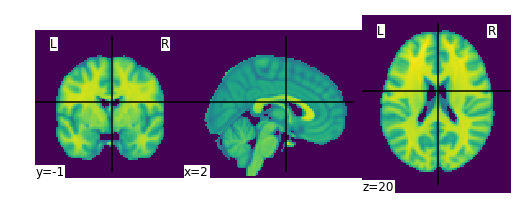

In [4]:
from nilearn import plotting
plotting.plot_img(MNI152_FILE_PATH)

**Exercise**: Try plotting one of your own files. In the above,
MNI152_FILE_PATH is nothing more than a string with a path pointing to
a nifti image. You can replace it with a string pointing to a file on
your disk. Note that it should be a 3D volume, and not a 4D volume.

In [ ]:
# Try to plot your own file here:


Extracting signals from a brain parcellation
============================================

Here we show how to extract signals from a brain parcellation and compute
a correlation matrix.

We also show the importance of defining good confounds signals: the
first correlation matrix is computed after regressing out simple
confounds signals: movement regressors, white matter and CSF signals, ...
The second one is without any confounds: all regions are connected to
each other.


One reference that discusses the importance of confounds is `Varoquaux and
Craddock, Learning and comparing functional connectomes across subjects,
NeuroImage 2013
<http://www.sciencedirect.com/science/article/pii/S1053811913003340>`_.

This is just a code example, see the `corresponding section in the
documentation <parcellation_time_series>` for more.

<div class="alert alert-info"><h4>Note</h4><p>This example needs SciPy >= 1.0.0 for the reordering of the matrix.</p></div>



Retrieve the atlas and the data
--------------------------------



In [ ]:
from nilearn import datasets
parcellations = datasets.fetch_atlas_basc_multiscale_2015()

In [ ]:
from nilearn import datasets

#dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
#atlas_filename = dataset.maps
#labels = dataset.labels
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064


print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

Let's have a look at that atlas

In [ ]:
import matplotlib.pyplot as plt
from nilearn import plotting

plotting.plot_roi(atlas_filename)


Great, let's load an example 4D fmri time-series for one subject

In [ ]:
# One subject of resting-state data
data = datasets.fetch_adhd(n_subjects=1)
fmri_filenames = data.func[0]
print('fmri timeseries are located in nifti image (4D) at: %s' %
       fmri_filenames)  # 4D data

And let's have a look at that

In [ ]:
plotting.plot_epi(fmri_filenames)

Uh oh! An error! What's the problem here?

In [ ]:
from nilearn.image import load_img
from nibabel import Nifti1Image
myImg = load_img(fmri_filenames)
myImg_data = myImg.get_data()
myImg_aff = myImg.affine

averaged_data = myImg_data.mean(axis=3)
averaged_Img = Nifti1Image(averaged_data, myImg_aff)

Let's try that again

In [ ]:
plotting.plot_epi(averaged_Img)

Extract signals on a parcellation defined by labels
-----------------------------------------------------
Using the NiftiLabelsMasker



In [ ]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           resampling_target='labels',
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
time_series = masker.fit_transform(myImg, confounds=data.confounds)

So what did we just create here?

In [ ]:
type(time_series)

In [ ]:
time_series.shape

Its a 176 (timeframes) x 64 (region) array!

What are these "confounds" and how are they used?

In [ ]:
data.confounds

In [ ]:
from pandas import read_csv
read_csv(data.confounds)
#read_csv(data.confounds[0])
#read_csv(data.confounds[0],sep='\t').head()

Compute and display a correlation matrix
-----------------------------------------



In [ ]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
correlation_matrix.shape

Plot the correlation matrix

In [ ]:
import numpy as np
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=True)

Same thing without confounds, to stress the importance of confounds
--------------------------------------------------------------------



In [ ]:
time_series = masker.fit_transform(fmri_filenames)
# Note how we did not specify confounds above. This is bad!

correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=range(time_series.shape[-1]),
                    title='No confounds', reorder=True)

plotting.show()